In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [ ]:
IS_COLAB = 1
MODEL_NAME = 'model2_128_early_stop'

In [ ]:
if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/ecgtrain/custom_cut_128_6_classes_dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train_data/PAB/217-108309.png  
  inflating: train_data/PAB/107-312467.png  
  inflating: train_data/PAB/217-282192.png  
  inflating: train_data/PAB/217-244298.png  
  inflating: train_data/PAB/107-421272.png  
  inflating: train_data/PAB/107-569213.png  
  inflating: train_data/PAB/217-239762.png  
  inflating: train_data/PAB/217-72327.png  
  inflating: train_data/PAB/217-633933.png  
  inflating: train_data/PAB/107-144179.png  
  inflating: train_data/PAB/107-396067.png  
  inflating: train_data/PAB/217-35024.png  
  inflating: train_data/PAB/217-473114.png  
  inflating: train_data/PAB/217-423924.png  
  inflating: train_data/PAB/107-643505.png  
  inflating: train_data/PAB/217-543369.png  
  inflating: train_data/PAB/217-265413.png  
  inflating: train_data/PAB/107-340636.png  
  inflating: train_data/PAB/107-386649.png  
  inflating: train_data/PAB/107-353442.png  
  inflating: train_data/PAB/107-381219.png  
  infl

In [ ]:
# Load data from CSV files
train_data = pd.read_csv("train.csv")
val_data = pd.read_csv("val.csv")
test_data = pd.read_csv("test.csv")

In [ ]:
test_data['label'].value_counts()

L      1941
PAB    1381
N       863
R       118
V        91
A        20
Name: label, dtype: int64

In [ ]:
label_mapping = {'N': 0, 'V': 1, 'PAB': 2, 'R': 3, 'L': 4, 'A': 5}
train_data = train_data.replace({'label': label_mapping})
val_data = val_data.replace({'label': label_mapping})
test_data = test_data.replace({'label': label_mapping})

# EDA

In [ ]:
# plot number of unique value in label column of newtrain.csv
train_data['label'].value_counts()

0    51578
1     5238
4     4466
3     4074
2     2896
5     1623
Name: label, dtype: int64

In [ ]:
val_data['label'].value_counts()

0    12894
1     1309
4     1116
3     1018
2      724
5      406
Name: label, dtype: int64

In [ ]:
test_data['label'].value_counts()


4    1941
2    1381
0     863
3     118
1      91
5      20
Name: label, dtype: int64

In [ ]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, df, num_classes, shuffle=False, batch_size = 10):
        self.indices = None
        self.length = None
        self.df: pd.DataFrame = df
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.__len__()
        self.on_epoch_end()

    def __len__(self):
        self.length = len(self.df) // self.batch_size
        if len(self.df) % self.batch_size != 0:
            self.length +=1
        return self.length

    def __getitem__(self, idx):
        X = []
        y = []
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        if idx == self.length-1:
            indices = self.indices[idx*self.batch_size:]
        for i, data_index in enumerate(indices):
            img_path = self.df.loc[data_index, 'path']
            img = load_img(img_path, color_mode="grayscale", target_size=(128, 128))
            img = img_to_array(img) / 255.0
            label = to_categorical(self.df.loc[data_index, 'label'], self.num_classes)

            X.append(img)
            y.append(label)
        X = np.stack(X)
        y = np.stack(y)
        return X, y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)


In [ ]:
BATCH_SIZE = 256 if IS_COLAB else 10

In [ ]:
train_gen = DataGenerator(df=train_data, batch_size=BATCH_SIZE, shuffle=True, num_classes=6)
val_gen = DataGenerator(df=val_data, batch_size=BATCH_SIZE, shuffle=False, num_classes=6)
test_gen = DataGenerator(df=test_data, batch_size=BATCH_SIZE, shuffle=False, num_classes=6)

In [ ]:

# Define CNN model
model = keras.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation="relu",
                      input_shape=(128, 128, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(6, activation="softmax"),
    ]
)


In [ ]:

# Compile model
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [ ]:
# Train model
CP_PATH = f'/content/drive/MyDrive/ecgtrain/{MODEL_NAME}' if IS_COLAB else 'tensorflow'
checkpoint = tf.keras.callbacks.ModelCheckpoint(CP_PATH, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cb_l = [checkpoint, early_stopping]
history = model.fit(
    train_gen, validation_data=val_gen, epochs=30, callbacks=cb_l
)

Epoch 1/30
273/273 [==============================] - ETA: 0s - loss: 0.2728 - accuracy: 0.9257
Epoch 1: accuracy improved from -inf to 0.92568, saving model to /content/drive/MyDrive/ecgtrain/model2_128_early_stop


273/273 [==============================] - 74s 211ms/step - loss: 0.2728 - accuracy: 0.9257 - val_loss: 0.0837 - val_accuracy: 0.9782
Epoch 2/30
273/273 [==============================] - ETA: 0s - loss: 0.0627 - accuracy: 0.9835
Epoch 2: accuracy improved from 0.92568 to 0.98348, saving model to /content/drive/MyDrive/ecgtrain/model2_128_early_stop


273/273 [==============================] - 50s 182ms/step - loss: 0.0627 - accuracy: 0.9835 - val_loss: 0.0597 - val_accuracy: 0.9849
Epoch 3/30
273/273 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 0.9882
Epoch 3: accuracy improved from 0.98348 to 0.98824, saving model to /content/drive/MyDrive/ecgtrain/model2_128_early_stop


273/273 [==============================] - 52s 189ms/step - loss: 0.0441 - accuracy: 0.9882 - val_loss: 0.0496 - val_accuracy: 0.9874
Epoch 4/30
273/273 [==============================] - ETA: 0s - loss: 0.0344 - accuracy: 0.9906
Epoch 4: accuracy improved from 0.98824 to 0.99057, saving model to /content/drive/MyDrive/ecgtrain/model2_128_early_stop


273/273 [==============================] - 51s 185ms/step - loss: 0.0344 - accuracy: 0.9906 - val_loss: 0.0479 - val_accuracy: 0.9873
Epoch 5/30
273/273 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 0.9927
Epoch 5: accuracy improved from 0.99057 to 0.99266, saving model to /content/drive/MyDrive/ecgtrain/model2_128_early_stop


273/273 [==============================] - 52s 189ms/step - loss: 0.0274 - accuracy: 0.9927 - val_loss: 0.0471 - val_accuracy: 0.9876
Epoch 6/30
273/273 [==============================] - ETA: 0s - loss: 0.0215 - accuracy: 0.9942
Epoch 6: accuracy improved from 0.99266 to 0.99416, saving model to /content/drive/MyDrive/ecgtrain/model2_128_early_stop


273/273 [==============================] - 51s 186ms/step - loss: 0.0215 - accuracy: 0.9942 - val_loss: 0.0474 - val_accuracy: 0.9888
Epoch 7/30
273/273 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 0.9951
Epoch 7: accuracy improved from 0.99416 to 0.99511, saving model to /content/drive/MyDrive/ecgtrain/model2_128_early_stop


273/273 [==============================] - 53s 193ms/step - loss: 0.0179 - accuracy: 0.9951 - val_loss: 0.0478 - val_accuracy: 0.9886
Epoch 8/30
273/273 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.9961
Epoch 8: accuracy improved from 0.99511 to 0.99605, saving model to /content/drive/MyDrive/ecgtrain/model2_128_early_stop


273/273 [==============================] - 50s 184ms/step - loss: 0.0138 - accuracy: 0.9961 - val_loss: 0.0488 - val_accuracy: 0.9887


In [ ]:
hist_dict = history.history

In [ ]:
# save history
import json
import os
# hist_dict = history.history
ECG_PATH = '/content/drive/MyDrive/ecgtrain/'
json.dump(hist_dict, open(os.path.join(ECG_PATH, MODEL_NAME, 'hist.json'), 'w'))

In [ ]:
model.save(os.path.join(ECG_PATH, MODEL_NAME, f'{MODEL_NAME}.h5'))

In [ ]:
os.path.join(ECG_PATH, MODEL_NAME, f'{MODEL_NAME}.h5')

'/content/drive/MyDrive/ecgtrain/model2_128_early_stop/model2_128_early_stop.h5'

In [ ]:
# load history
hist = json.load(open(os.path.join(ECG_PATH, MODEL_NAME, 'hist.json'), 'r'))

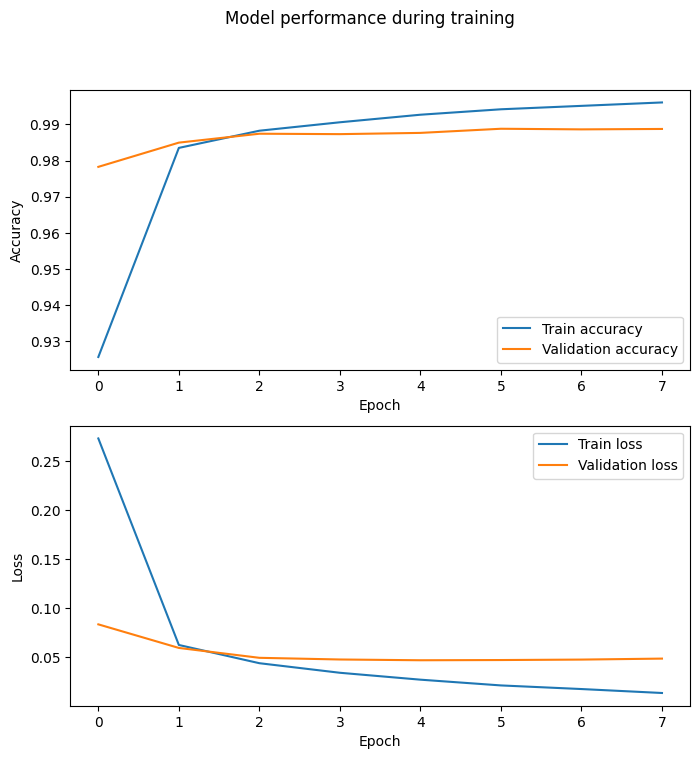

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
axes[0].plot(hist['accuracy'])
axes[0].plot(hist['val_accuracy'])
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[1].plot(hist['loss'])
axes[1].plot(hist['val_loss'])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
fig.suptitle('Model performance during training')
axes[0].legend(('Train accuracy', 'Validation accuracy'))
axes[1].legend(('Train loss', 'Validation loss'))

In [ ]:
test_labels = to_categorical(test_data["label"], num_classes=6)

In [ ]:
test_loss, test_acc = model.evaluate(test_gen, verbose=2)

18/18 - 3s - loss: 5.5647 - accuracy: 0.5317 - 3s/epoch - 166ms/step


In [ ]:
label_mapping = {'N': 0, 'V': 1, 'PAB': 2, 'R': 3, 'L': 4, 'A': 5}

18/18 - 4s - loss: 5.5647 - accuracy: 0.5317 - 4s/epoch - 234ms/step
Test accuracy: 0.5317172408103943
Test loss: 5.564702033996582
18/18 [==============================] - 3s 136ms/step
[[ 862    0    0    1    0    0]
 [   1   89    1    0    0    0]
 [   0    0 1381    0    0    0]
 [   0  103    0   15    0    0]
 [  29 1912    0    0    0    0]
 [  17    3    0    0    0    0]]


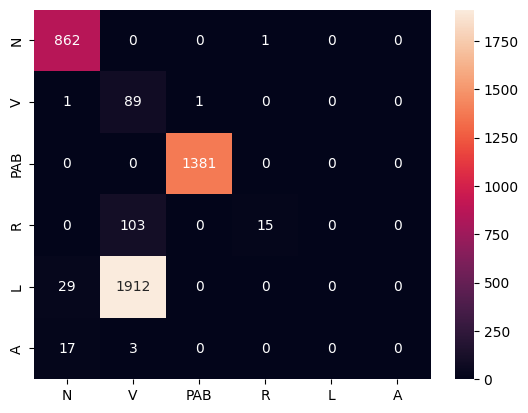

In [ ]:
# test model
test_loss, test_acc = model.evaluate(test_gen, verbose=2)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

# print confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)
sns.heatmap(cm, annot=True, xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys(), fmt="d")
plt.show()



In [ ]:
# print classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       863
           1       0.04      0.98      0.08        91
           2       1.00      1.00      1.00      1381
           3       0.94      0.13      0.22       118
           4       0.00      0.00      0.00      1941
           5       0.00      0.00      0.00        20

    accuracy                           0.53      4414
   macro avg       0.49      0.52      0.38      4414
weighted avg       0.52      0.53      0.51      4414



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
!unzip '/content/drive/MyDrive/ecgtrain/128_test_data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: 128_test_data/V/106_263825.png  
  inflating: 128_test_data/V/106_384153.png  
  inflating: 128_test_data/V/106_613704.png  
  inflating: 128_test_data/V/106_595323.png  
  inflating: 128_test_data/V/106_427235.png  
  inflating: 128_test_data/V/107_554239.png  
  inflating: 128_test_data/V/106_350322.png  
  inflating: 128_test_data/V/106_288389.png  
  inflating: 128_test_data/V/106_581505.png  
  inflating: 128_test_data/V/106_418235.png  
  inflating: 128_test_data/V/106_585074.png  
  inflating: 128_test_data/V/106_266387.png  
  inflating: 128_test_data/V/106_519526.png  
  inflating: 128_test_data/V/106_329977.png  
  inflating: 128_test_data/V/106_308531.png  
  inflating: 128_test_data/V/106_560919.png  
  inflating: 128_test_data/V/106_294622.png  
  inflating: 128_test_data/V/106_303753.png  
  inflating: 128_test_data/V/106_523512.png  
  inflating: 128_test_data/V/106_640877.png  
  inflating: 128_test_data/V/

In [ ]:
test_data2 = pd.read_csv("test2.csv")
test_data2['label'].value_counts()
label_mapping = {'N': 0, 'V': 1, 'PAB': 2, 'R': 3, 'L': 4, 'A': 5}
test_data2 = test_data2.replace({'label': label_mapping})
test_gen2 = DataGenerator(df=test_data2, batch_size=BATCH_SIZE, shuffle=False, num_classes=6)

In [ ]:
test_labels2 = to_categorical(test_data2["label"], num_classes=6)

72/72 - 9s - loss: 0.0336 - accuracy: 0.9914 - 9s/epoch - 125ms/step
Test accuracy: 0.9914271831512451
Test loss: 0.03355466201901436
72/72 [==============================] - 10s 136ms/step
[[10273    19     1     2     2    12]
 [    8   626     0     0     1     0]
 [    1     1  2076     0     0     0]
 [    2     0     0  2161     0     3]
 [   12    11     0     1  2467     1]
 [   70     0     0     9     0   438]]


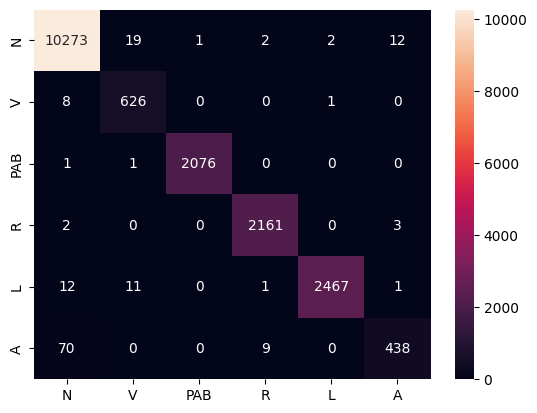

In [ ]:
# test model
test_loss2, test_acc2 = model.evaluate(test_gen2, verbose=2)
print("Test accuracy:", test_acc2)
print("Test loss:", test_loss2)

# print confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred2 = model.predict(test_gen2)
y_pred2 = np.argmax(y_pred2, axis=1)
y_true2 = np.argmax(test_labels2, axis=1)
cm2 = confusion_matrix(y_true2, y_pred2)
print(cm2)
sns.heatmap(cm2, annot=True, xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys(), fmt="d")
plt.show()



In [ ]:
# print classification report
from sklearn.metrics import classification_report
print(classification_report(y_true2, y_pred2))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10309
           1       0.95      0.99      0.97       635
           2       1.00      1.00      1.00      2078
           3       0.99      1.00      1.00      2166
           4       1.00      0.99      0.99      2492
           5       0.96      0.85      0.90       517

    accuracy                           0.99     18197
   macro avg       0.98      0.97      0.98     18197
weighted avg       0.99      0.99      0.99     18197



In [ ]:
# # convert to labels
# labels = np.argmax(yhat, axis=1)
# # print labels
# print(labels)

# # print frequency of each label in separated lines
# arr_rs = np.unique(labels, return_counts=True)
# print('---------------------------------')
# for i in range(len(arr_rs[0])):
#     print(arr_rs[0][i], " - ", arr_rs[1][i])
